# **IMPORT IMPORTANT LIBRARIES**

In [ ]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pathlib
import urllib.request
import seaborn as sns
from google.colab import files
from shutil import copyfile
from IPython.display import clear_output
from sklearn.metrics import confusion_matrix
from collections import Counter

import PIL
import PIL.Image
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# **SET HYPERPARAMETER**

In [ ]:
BATCH_SIZE = 32
IMG_HEIGHT = 150
IMG_WIDTH = 150
EPOCHS = 10

# **DATA PIPELINING**

# **Extract**

In [ ]:
# Mengunduh dataset dari GitHub dengan git clone
!git clone https://github.com/zidan2808/ART-DATASET.git

# Mengatur path ke folder dataset
dataset_dir = 'ART-DATASET/Surreal Symphonies (A dataset of Diverse Artistic Visions)'

# Buat direktori baru untuk menyimpan gambar yang telah diproses
preprocessed_dir = 'preprocessed_symphonies'
if not os.path.exists(preprocessed_dir):
    os.makedirs(preprocessed_dir)

Cloning into 'ART-DATASET'...
remote: Enumerating objects: 1626, done.
remote: Total 1626 (delta 0), reused 0 (delta 0), pack-reused 1626
Receiving objects: 100% (1626/1626), 1.05 GiB | 49.35 MiB/s, done.
Resolving deltas: 100% (38/38), done.
Updating files: 100% (11492/11492), done.


In [ ]:
# Fungsi untuk mendapatkan daftar kelas dan jumlah masing-masing kelas
def get_class_distribution(dataset_dir):
    class_counts = Counter()

    # Loop melalui subdirektori dalam dataset_dir
    for root, dirs, files in os.walk(dataset_dir):
        for dir_name in dirs:
            class_dir = os.path.join(root, dir_name)
            num_images = len([f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))])
            # Nama kelas diambil dari nama subdirektori terakhir
            class_name = os.path.basename(class_dir)
            class_counts[class_name] += num_images

    return class_counts

# Mendapatkan jumlah masing-masing kelas
class_counts = get_class_distribution(dataset_dir)

# Menghitung total jumlah kelas dan total jumlah file
num_classes = len(class_counts)
total_file_count = sum(class_counts.values())

# Membuat DataFrame dari hasil penghitungan
class_counts_df = pd.DataFrame.from_dict(class_counts, orient='index', columns=['Jumlah'])
class_counts_df.index.name = 'Genre'
class_counts_df.reset_index(inplace=True)

# Menampilkan tabel
print(class_counts_df)

# Menampilkan total jumlah kelas dan total jumlah file
print(f"\nTotal Jenis Genre Seni: {num_classes}")
print(f"Total Jumlah FIle: {total_file_count}")

                               Genre  Jumlah
0                 Art deco paintings     520
1                  Fauvism paintings     564
2                   Contemporary art     574
3                          Naive art     253
4                   Neoclassical art     277
5              Romanticism paintings     285
6                 Surrealism artwork      18
7         Post-impressionism artwork     260
8              Art Nouveau paintings     508
9                    Dadaism artwork     518
10  Abstract expressionism paintings     506
11              Surrealist paintings     297
12                 Modernism artwork      21
13                        Cubism art     580
14                           Pop art     261
15             Impressionism artwork     524
16                 Symbolism artwork     258
17             Neo-expressionism art     284
18           Expressionism paintings     574
19                       Digital art     558
20                      Academic art     440
21        

In [ ]:
# Fungsi untuk mendapatkan daftar kelas dan jumlah masing-masing kelas
def get_class_distribution(dataset_dir):
    class_counts = Counter()
    extension_counts = Counter()

    # Loop melalui subdirektori dalam dataset_dir
    for root, dirs, files in os.walk(dataset_dir):
        for dir_name in dirs:
            class_dir = os.path.join(root, dir_name)
            num_images = len([f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))])
            # Nama kelas diambil dari nama subdirektori terakhir
            class_name = os.path.basename(class_dir)
            class_counts[class_name] += num_images

            # Menghitung jumlah file berdasarkan ekstensi
            for file in os.listdir(class_dir):
                if os.path.isfile(os.path.join(class_dir, file)):
                    file_extension = os.path.splitext(file)[1].lower()
                    extension_counts[file_extension] += 1

    return class_counts, extension_counts

# Mendapatkan jumlah masing-masing kelas dan ekstensi file
class_counts, extension_counts = get_class_distribution(dataset_dir)

# Membuat DataFrame dari hasil penghitungan ekstensi
extension_counts_df = pd.DataFrame.from_dict(extension_counts, orient='index', columns=['Jumlah'])
extension_counts_df.index.name = 'Ekstensi'
extension_counts_df.reset_index(inplace=True)

# Menampilkan tabel
print(extension_counts_df)

  Ekstensi  Jumlah
0     .jpg    7327
1     .png    4165


# **Transform**

In [ ]:
# Fungsi untuk memproses dan menyimpan gambar
def preprocess_and_save_image(image_path, save_path):
    with Image.open(image_path) as img:
        img = img.resize((IMG_HEIGHT, IMG_WIDTH))  # Mengubah ukuran gambar
        img.save(save_path, 'PNG')  # Menyimpan gambar sebagai PNG

# Menelusuri direktori dataset dan memproses gambar
for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        if file.lower().endswith(('jpg', 'jpeg', 'png', 'bmp', 'gif')):
            image_path = os.path.join(root, file)
            relative_path = os.path.relpath(image_path, dataset_dir)
            save_path = os.path.join(preprocessed_dir, os.path.splitext(relative_path)[0] + '.png')

            # Membuat direktori jika belum ada
            os.makedirs(os.path.dirname(save_path), exist_ok=True)

            # Memproses dan menyimpan gambar
            preprocess_and_save_image(image_path, save_path)

print("Semua gambar telah diproses dan disimpan sebagai PNG.")

# **Load**

In [ ]:
# Menggunakan ImageDataGenerator untuk memuat gambar yang telah diproses
datagen = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.2)

train_dataset = datagen.flow_from_directory(
    preprocessed_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),  # Ukuran gambar
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # Gunakan 'categorical' untuk beberapa kelas
    subset='training'
)

validation_dataset = datagen.flow_from_directory(
    preprocessed_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),  # Ukuran gambar
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # Gunakan 'categorical' untuk beberapa kelas
    subset='validation'
)

In [ ]:
class_indices = train_dataset.class_indices
num_classes = len(class_indices)
print(f"Jumlah kelas: {num_classes}")
print("Label kelas:", class_indices)

In [ ]:
class_indices = validation_dataset.class_indices
num_classes = len(class_indices)
print(f"Jumlah kelas: {num_classes}")
print("Label kelas:", class_indices)

In [ ]:
# Menampilkan beberapa contoh gambar
def plot_images(images_arr, labels_arr, class_indices, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 20))
    axes = axes.flatten()
    for img, lbl, ax in zip(images_arr, labels_arr, axes):
        ax.imshow(img)
        label = list(class_indices.keys())[list(class_indices.values()).index(np.argmax(lbl))]
        ax.set_title(label)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Mendapatkan batch gambar dan label
images, labels = next(train_dataset)

# Menampilkan 5 contoh gambar
plot_images(images[:5], labels[:5], class_indices, num_images=5)

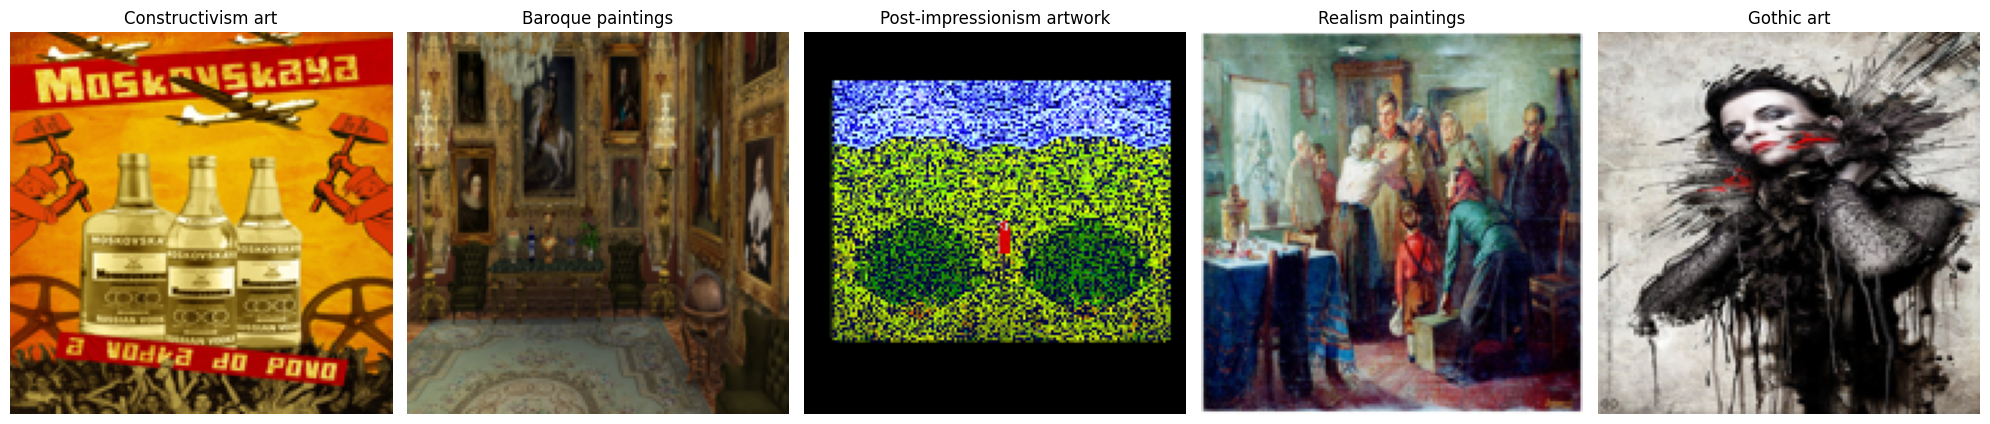

In [ ]:
# Mendapatkan batch gambar dan label
images, labels = next(validation_dataset)

# Menampilkan 5 contoh gambar
plot_images(images[:5], labels[:5], class_indices, num_images=5)

In [ ]:
weights_url = "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
weights_file = "inception_v3.h5"
urllib.request.urlretrieve(weights_url, weights_file)

# Instantiate the model
pre_trained_model = InceptionV3(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                                include_top=False,
                                weights=None)

# load pre-trained weights
pre_trained_model.load_weights(weights_file)

# freeze the layers
for layer in pre_trained_model.layers:
    layer.trainable = False

# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

In [ ]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a final sigmoid layer for classification
x = layers.Dense(30, activation='softmax')(x)

model = Model(pre_trained_model.input, x)


In [ ]:
# compile the model
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])

# train the model (adjust the number of epochs from 1 to improve performance)
history = model.fit(
            train_dataset,
            validation_data=validation_dataset,
            epochs=EPOCHS,
            verbose=1)

In [ ]:
import numpy as np
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

# Fungsi untuk memuat label kelas dari train_generator
def load_class_labels(generator):
    class_indices = generator.class_indices
    return {v: k for k, v in class_indices.items()}

class_labels = load_class_labels(validation_dataset)

# Mengunggah file
uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = '/content/' + fn
  img = load_img(path, target_size=(150, 150))
  x = img_to_array(img)
  x /= 255.0
  x = np.expand_dims(x, axis=0)

  image_tensor = np.vstack([x])
  classes = model.predict(image_tensor)

  # Mendapatkan indeks kelas dengan probabilitas tertinggi
  top_3_indices = np.argsort(classes[0])[-3:][::-1]

  print(f"Predictions for {fn}:")
  for i in top_3_indices:
    class_name = class_labels[i]
    probability = classes[0][i]
    print(f"Class: {class_name}, Probability: {probability:.2f}")
